This notebook demonstrates the use of our linear approximation for sensitivity with respect to the Dirichlet process $\alpha$ parameter

In [1]:
import autograd
from autograd import numpy as np
from autograd import scipy as sp

from numpy.polynomial.hermite import hermgauss

np.random.seed(453453)

import paragami

# BNP sensitivity libraries
import bnpgmm_runjingdev.gmm_clustering_lib as gmm_lib
import bnpgmm_runjingdev.gmm_cavi_lib as cavi_lib

import bnpmodeling_runjingdev.modeling_lib as modeling_lib 
import bnpgmm_runjingdev.utils_lib as utils_lib
import bnpmodeling_runjingdev.cluster_quantities_lib as cluster_lib
import bnpmodeling_runjingdev.optimization_lib as optimization_lib

import bnpgmm_runjingdev.hessian_lib as hessian_lib
import bnpgmm_runjingdev.gmm_preconditioner_lib as preconditioner_lib

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

from sklearn.decomposition import PCA

from copy import deepcopy

import vittles

import json 

import time

/home/rliu/anaconda3/envs/bnp_sensitivity/lib/python3.8/site-packages/autograd/core.py:290: UserWarning: 
The defvjp method is deprecated. See the update guide and tutorial:
https://github.com/HIPS/autograd/blob/master/docs/updateguide.md
https://github.com/HIPS/autograd/blob/master/docs/tutorial.md
  warnings.warn(deprecation_msg)


# Load data

We load and plot the iris dataset

In [2]:
# load iris data
dataset_name = 'iris'
features, iris_species = utils_lib.load_data()
dim = features.shape[1]
n_obs = len(iris_species)    

Text(0, 0.5, 'PC2')

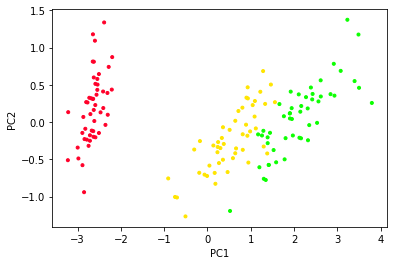

In [3]:
# run PCA
pca_fit = PCA()
pca_fit.fit(features)
pc_features = pca_fit.transform(features)

# plot
cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(30)]

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], iris_species, colors1, fig)
fig.set_xlabel('PC1')
fig.set_ylabel('PC2')


# Set up model

### Prior parameters

In [4]:
# Get priors
prior_params_dict, prior_params_paragami = gmm_lib.get_default_prior_params(dim)
prior_params_dict['alpha'] = 3.5
print(prior_params_dict)

{'alpha': 3.5, 'prior_centroid_mean': array([0.]), 'prior_lambda': array([1.]), 'prior_wishart_df': array([10.]), 'prior_wishart_rate': array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])}


### Variational parameters

In [5]:
# number of clusters in variational distribution 
k_approx = 30

In [6]:
# Gauss-Hermite points for integrating logitnormal stick-breaking prior
gh_deg = 8
gh_loc, gh_weights = hermgauss(gh_deg)

In [7]:
# get vb parameters
vb_params_dict, vb_params_paragami = gmm_lib.get_vb_params_paragami_object(dim, k_approx)

In [8]:
# the objective 
gmm_lib.get_kl(features, vb_params_dict, prior_params_dict, gh_loc, gh_weights)

1747.195163331245

# Optimize the KL objective

### Initialize with k-means

In [9]:
# run a kmeans init
n_kmeans_init = 50
init_vb_free_params, init_vb_params_dict, init_ez = \
    utils_lib.cluster_and_get_k_means_inits(features, vb_params_paragami, 
                                                n_kmeans_init = n_kmeans_init, 
                                                  seed = 453453)

print('initial kl: ')
print(gmm_lib.get_kl(features, init_vb_params_dict, prior_params_dict, gh_loc, gh_weights))

initial kl: 
4855.740571596972


In [10]:
vb_params_dict = deepcopy(init_vb_params_dict)

### Run CAVI

In [11]:
x_tol = 1e-3
vb_opt_dict, e_z_opt = cavi_lib.run_cavi(features, vb_params_dict,
                                            vb_params_paragami, prior_params_dict,
                                            gh_loc, gh_weights,
                                            debug = False, 
                                            x_tol = x_tol)

done. num iterations = 94
stick_time: 0.506sec
cluster_time: 0.045sec
e_z_time: 0.128sec
**TOTAL time: 1.544sec**


In [12]:
vb_opt = vb_params_paragami.flatten(vb_opt_dict, free = True)

### Check results

In [13]:
def plot_results_from_vb_params_dict(pca_fit, vb_params_dict, e_z, fig): 
    # we plot in PCA space
    bnp_centroids_pc, bnp_cluster_covs_pc = \
        utils_lib.transform_params_to_pc_space(pca_fit, vb_params_dict['cluster_params']['centroids'], 
                                               np.linalg.inv(vb_params_dict['cluster_params']['cluster_info']))
    
    bnp_clusters = np.argmax(e_z, axis = 1)
    
    cmap = cm.get_cmap(name='gist_rainbow')
    colors1 = [cmap(k * 50) for k in range(30)]

    utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
                  colors1, fig, \
                  centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], 
                cov = bnp_cluster_covs_pc[np.unique(bnp_clusters)])


Text(0, 0.5, 'PC2')

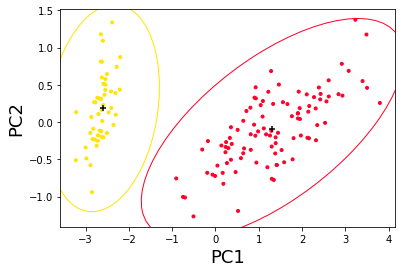

In [14]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_results_from_vb_params_dict(pca_fit, vb_opt_dict, e_z_opt, fig)
fig.set_xlabel('PC1', fontsize = 18)
fig.set_ylabel('PC2', fontsize = 18)


# Parametric sensitivity

### Get the hyper parameter sensitivity object

In [15]:
use_free_alpha = True
prior_alpha = prior_params_paragami['alpha'].flatten(prior_params_dict['alpha'], free = use_free_alpha)

In [16]:
# set up objective as function of vb params and prior param 

def objective_fun(vb_params_dict, alpha): 
    
    _prior_params_dict = deepcopy(prior_params_dict)
    _prior_params_dict['alpha'] = alpha
    
    return gmm_lib.get_kl(features, vb_params_dict, _prior_params_dict,
                    gh_loc, gh_weights)


objective_fun_free = paragami.FlattenFunctionInput(
                                original_fun=objective_fun, 
                                patterns = [vb_params_paragami, prior_params_paragami['alpha']],
                                free = [True, use_free_alpha],
                                argnums = [0, 1])

In [17]:
# get nystrom preconditioner
k_large = 5
which_k = np.argsort(-e_z_opt.mean(0))[0:k_large]

sub_block_hess, indx = hessian_lib.get_large_clusters_hessian(features, which_k, vb_opt, vb_params_paragami, 
                                                                  prior_params_dict, gh_loc, gh_weights)

est_lambda_max = np.abs(sub_block_hess).sum(1).max()
nystrom_precond = preconditioner_lib.get_nystrom_woodbury_precon(sub_block_hess, indx, est_lambda_max)

In [18]:
# get solver 
obj_fun_hvp = autograd.hessian_vector_product(objective_fun_free, argnum = 0)

hess_solver = vittles.solver_lib.get_cg_solver(lambda x : obj_fun_hvp(vb_opt, prior_alpha, x), 
                                                        dim = len(vb_opt), 
                                                        cg_opts={'M':nystrom_precond})


In [19]:
t0 = time.time()
vb_sens = \
    vittles.HyperparameterSensitivityLinearApproximation(
        objective_fun = objective_fun_free, 
        opt_par_value = vb_opt, 
        hyper_par_value = prior_alpha, 
        hess_solver = hess_solver)

print('solver time: ', time.time() - t0)

solver time:  3.229445457458496


### Set new prior

In [20]:
new_alpha = np.array([5.])

prior_params_pert_dict = deepcopy(prior_params_dict)
prior_params_pert_dict['alpha'] = new_alpha


In [21]:
print('initial alpha, ', prior_params_dict['alpha'])
print('perturbed alpha, ', prior_params_pert_dict['alpha'])

initial alpha,  3.5
perturbed alpha,  [5.]


### get linear response prediction

In [22]:
lr_vb_free_params = \
    vb_sens.predict_opt_par_from_hyper_par(
        prior_params_paragami['alpha'].flatten(prior_params_pert_dict['alpha'], free = use_free_alpha))

In [23]:
print('l_inf diff: ', np.max(np.abs(lr_vb_free_params - vb_opt)))

l_inf diff:  0.41009823398122824


### re-optimize

In [24]:
new_init_dict = deepcopy(vb_opt_dict)
new_init_free = vb_params_paragami.flatten(new_init_dict, free = True)

In [25]:
vb_pert_dict, e_z_pert = cavi_lib.run_cavi(features, deepcopy(new_init_dict),
                                        vb_params_paragami, prior_params_pert_dict,
                                        gh_loc, gh_weights,
                                       debug = False)

vb_opt_pert = vb_params_paragami.flatten(vb_pert_dict, free = True)

done. num iterations = 56
stick_time: 0.315sec
cluster_time: 0.027sec
e_z_time: 0.076sec
**TOTAL time: 0.922sec**


### Compare linear response with refitting

In [26]:
def print_diff_plot(lr_vb_free_params, vb_opt_pert, vb_opt): 
    plt.plot(lr_vb_free_params - vb_opt, 
             vb_opt_pert - vb_opt, 
             '+', color = 'red')

    plt.plot(lr_vb_free_params - vb_opt, 
            lr_vb_free_params - vb_opt, 
             '-', color = 'blue')

    plt.xlabel('lr')
    plt.ylabel('re-optimized')

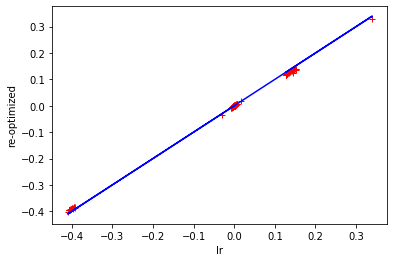

In [27]:
print_diff_plot(lr_vb_free_params, vb_opt_pert, vb_opt)

# Fit for a range of alpha 

In [28]:
alpha_list = np.arange(1, 15)

In [29]:
def refit_with_alpha(alpha, new_init_dict):
    # sets new alpha, returns new vb optimum
    
    # set new prior
    new_alpha = np.array([alpha])

    prior_params_pert_dict = deepcopy(prior_params_dict)
    prior_params_pert_dict['alpha'] = new_alpha
    
    vb_pert_dict, e_z_pert = cavi_lib.run_cavi(features, deepcopy(new_init_dict),
                                            vb_params_paragami, prior_params_pert_dict,
                                            gh_loc, gh_weights,
                                           debug = False)

    vb_opt_pert = vb_params_paragami.flatten(vb_pert_dict, free = True)   
        
    return vb_opt_pert

### Re-optimize for range of alphas

In [30]:
print('alphas: ', alpha_list)

alphas:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [31]:
vb_pert_list = []
for alpha in alpha_list: 
    print('\n re-optimzing with alpha = ', alpha)
    
    vb_pert_list.append(refit_with_alpha(alpha, new_init_dict))


 re-optimzing with alpha =  1
done. num iterations = 89
stick_time: 0.446sec
cluster_time: 0.043sec
e_z_time: 0.12sec
**TOTAL time: 1.408sec**

 re-optimzing with alpha =  2
done. num iterations = 59
stick_time: 0.304sec
cluster_time: 0.031sec
e_z_time: 0.082sec
**TOTAL time: 0.965sec**

 re-optimzing with alpha =  3
done. num iterations = 32
stick_time: 0.158sec
cluster_time: 0.015sec
e_z_time: 0.042sec
**TOTAL time: 0.502sec**

 re-optimzing with alpha =  4
done. num iterations = 40
stick_time: 0.199sec
cluster_time: 0.018sec
e_z_time: 0.053sec
**TOTAL time: 0.63sec**

 re-optimzing with alpha =  5
done. num iterations = 56
stick_time: 0.282sec
cluster_time: 0.027sec
e_z_time: 0.075sec
**TOTAL time: 0.88sec**

 re-optimzing with alpha =  6
done. num iterations = 72
stick_time: 0.359sec
cluster_time: 0.032sec
e_z_time: 0.094sec
**TOTAL time: 1.122sec**

 re-optimzing with alpha =  7
done. num iterations = 77
stick_time: 0.481sec
cluster_time: 0.041sec
e_z_time: 0.117sec
**TOTAL time:

### get linear response prediction for each alpha

In [32]:
lr_list = []

for alpha in alpha_list: 
    
    # set alpha 
    new_alpha = np.array([alpha])
    prior_params_pert_dict = deepcopy(prior_params_dict)
    prior_params_pert_dict['alpha'] = new_alpha
    
    # get linear response
    lr_list.append(vb_sens.predict_opt_par_from_hyper_par(
        prior_params_paragami['alpha'].flatten(prior_params_pert_dict['alpha'], free = use_free_alpha)))

### examine results 

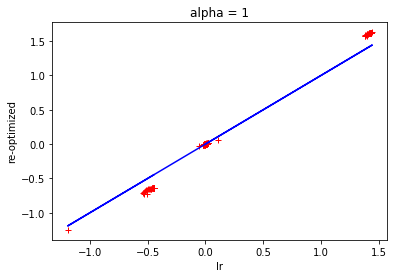

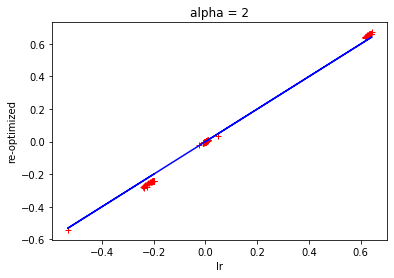

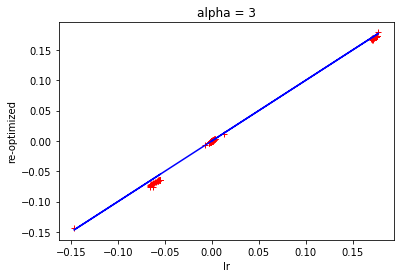

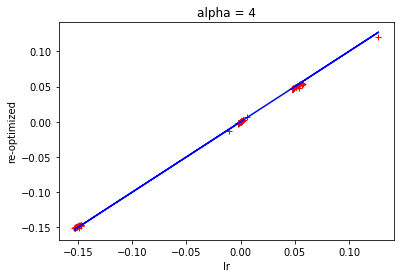

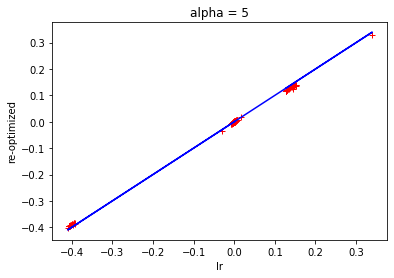

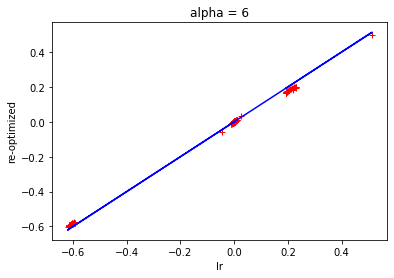

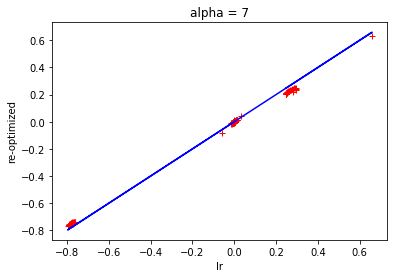

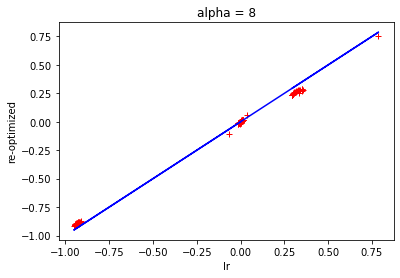

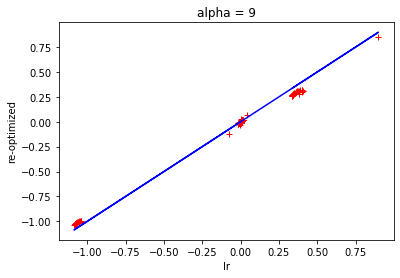

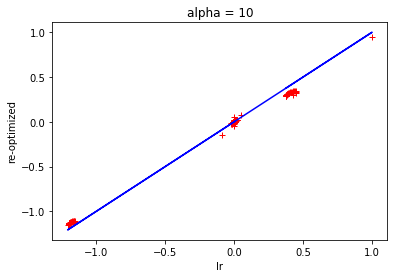

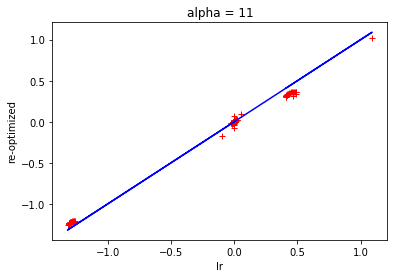

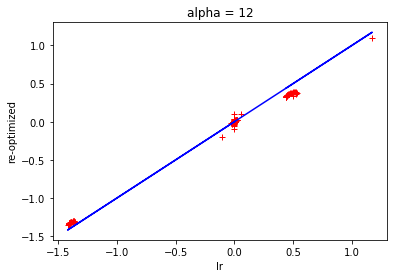

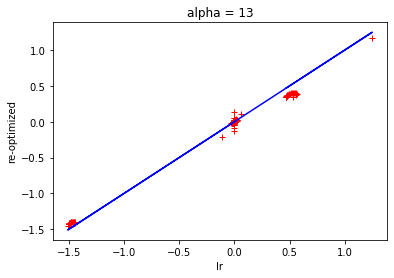

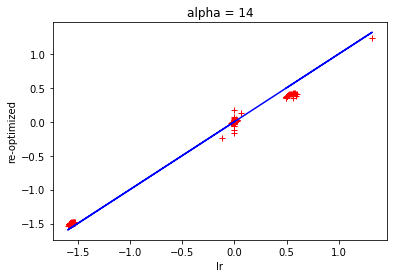

In [33]:
for i in range(len(alpha_list)): 
    plt.figure()
    print_diff_plot(lr_list[i], vb_pert_list[i], vb_opt)
    
    plt.title('alpha = {}'.format(alpha_list[i]))
    

# Check results on number of clusters

### results on number of in-sample clusters

In [34]:
threshold = 0

lr_e_num_clusters_vec = np.zeros(len(alpha_list))
refit_e_num_clusters_vec = np.zeros(len(alpha_list))

for i in range(len(alpha_list)): 
    # number of clusters as predicted by linear response
    lr_e_num_clusters, _ = gmm_lib.get_e_num_clusters_from_free_par(features, vb_params_paragami, 
                                    lr_list[i],
                                    gh_loc, gh_weights,
                                    threshold = threshold,
                                    n_samples = 100000)
    
    lr_e_num_clusters_vec[i] = lr_e_num_clusters
    
    # number of clusters after refitting 
    refit_e_num_clusters, _ = gmm_lib.get_e_num_clusters_from_free_par(features, vb_params_paragami, 
                                    vb_pert_list[i],
                                    gh_loc, gh_weights,
                                    threshold = threshold,
                                    n_samples = 100000)
    
    refit_e_num_clusters_vec[i] = refit_e_num_clusters
    


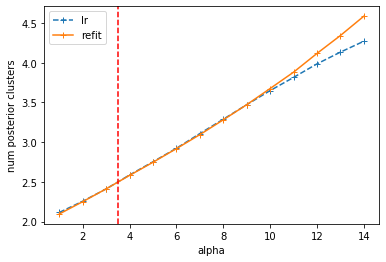

In [35]:
plt.plot(alpha_list, lr_e_num_clusters_vec, '+--')
plt.plot(alpha_list, refit_e_num_clusters_vec, '+-')

plt.xlabel('alpha')
plt.ylabel('num posterior clusters')
plt.legend(('lr', 'refit'))

plt.axvline(prior_params_dict['alpha'], color = 'red', linestyle = 'dashed')


### Results on posterior predictive clusters

In [36]:
threshold = 0

lr_e_num_pred_clusters_vec = np.zeros(len(alpha_list))
refit_e_num_pred_clusters_vec = np.zeros(len(alpha_list))

for i in range(len(alpha_list)): 
     # number of clusters as predicted by linear response
    lr_e_num_pred_clusters = gmm_lib.get_e_num_pred_clusters_from_vb_free_params(vb_params_paragami, 
                                    lr_list[i],
                                    n_obs = np.shape(features)[0], 
                                    threshold = threshold,
                                    n_samples = 100000)
    
    lr_e_num_pred_clusters_vec[i] = lr_e_num_pred_clusters
    
    # number of clusters after refitting 
    refit_e_num_pred_clusters = gmm_lib.get_e_num_pred_clusters_from_vb_free_params(vb_params_paragami, 
                                    vb_pert_list[i],
                                    n_obs = np.shape(features)[0], 
                                    threshold = threshold,
                                    n_samples = 100000)
    
    refit_e_num_pred_clusters_vec[i] = refit_e_num_pred_clusters
    


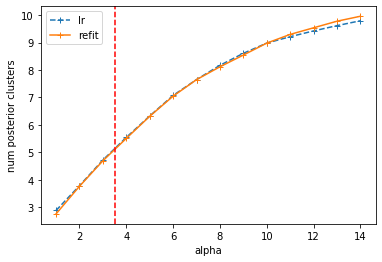

In [37]:
plt.plot(alpha_list, lr_e_num_pred_clusters_vec, '+--')
plt.plot(alpha_list, refit_e_num_pred_clusters_vec, '+-')

plt.xlabel('alpha')
plt.ylabel('num posterior clusters')
plt.legend(('lr', 'refit'))

plt.axvline(prior_params_dict['alpha'], color = 'red', linestyle = 'dashed')
